# KAGGLE. Сериал "Игровая площадка", 3 сезон, 2 серия
# Прогноз инсульта

Dataset Description:  
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

# Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from catboost.utils import get_roc_curve, select_threshold
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from imblearn.over_sampling import SMOTENC, SMOTE


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

state = 10012023

In [2]:
# функции

# функция для изучения данных
def def_info(df):
    print('Размер таблицы:', df.shape)
    print('____________________________________')
    print()
    print('Общая информация')
    print(df.info())
    print('____________________________________')
    print()
    print('Вывод 5и первых строк')
    display(df.head())
    print('____________________________________')
    print()
    print('Доля пропусков в таблице:')
    print(df.isna().mean())
    print('____________________________________')
    print()
    print('Доля явных дублей в данных:', df.duplicated().mean())

# функция для изучения выбросов и аномалий в данных
def boxplot_make(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist)
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');
    
# функция для изучения распределения данных по целевому признаку
def result_table(data, column, target):
    table = (data.groupby(column)[target].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')
    return table

In [3]:
# чтение данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
def_info(train)

Размер таблицы: (15304, 12)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB
None
____________________________________

Вывод 5и первых строк


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


____________________________________

Доля пропусков в таблице:
id                   0.0
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [5]:
def_info(test)

Размер таблицы: (10204, 11)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10204 non-null  int64  
 1   gender             10204 non-null  object 
 2   age                10204 non-null  float64
 3   hypertension       10204 non-null  int64  
 4   heart_disease      10204 non-null  int64  
 5   ever_married       10204 non-null  object 
 6   work_type          10204 non-null  object 
 7   Residence_type     10204 non-null  object 
 8   avg_glucose_level  10204 non-null  float64
 9   bmi                10204 non-null  float64
 10  smoking_status     10204 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 877.0+ KB
None
____________________________________

Вывод 5и первых строк


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


____________________________________

Доля пропусков в таблице:
id                   0.0
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [6]:
# названия столбцов приведем к нижнему регистру
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

# Короткий исследовательский анализ

In [7]:
train.describe(include='object')

,gender,ever_married,work_type,residence_type,smoking_status
count,15304,15304,15304,15304,15304
unique,3,2,5,2,4
top,Female,Yes,Private,Rural,never smoked
freq,9446,10385,9752,7664,6281


In [8]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [9]:
test.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000
mean,20405.500000,41.920713,0.051450,0.021756,89.197766,28.242351
std,2945.785407,21.097956,0.220925,0.145894,25.914364,6.733863
min,15304.000000,0.080000,0.000000,0.000000,55.120000,11.500000
25%,17854.750000,26.000000,0.000000,0.000000,75.060000,23.700000
50%,20405.500000,43.500000,0.000000,0.000000,85.070000,27.700000
75%,22956.250000,57.000000,0.000000,0.000000,96.750000,32.000000
max,25507.000000,82.000000,1.000000,1.000000,267.600000,97.600000


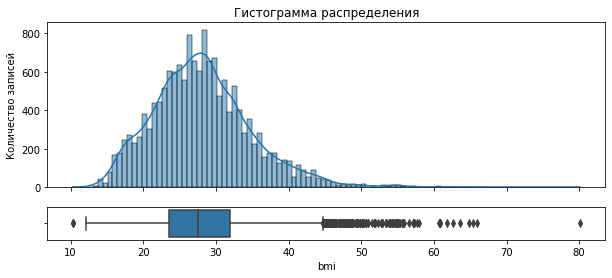

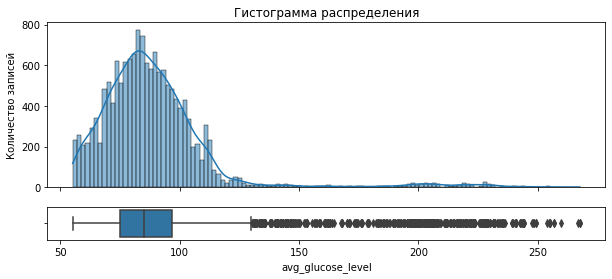

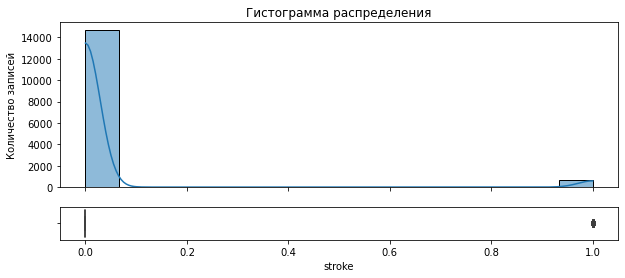

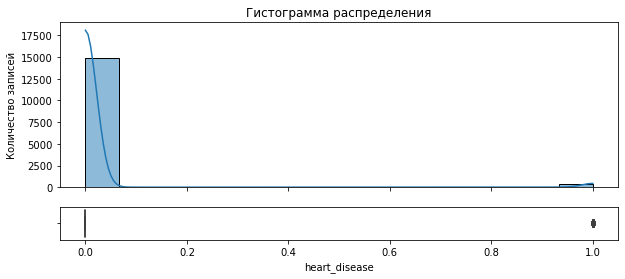

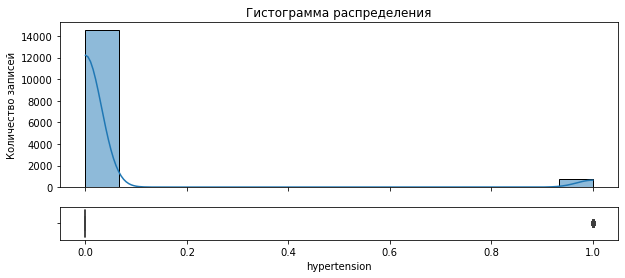

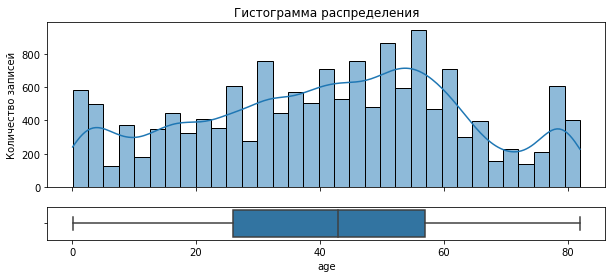

In [10]:
# проверим данные на аномалии и посмотрим распределение
for col in set(train.select_dtypes(include='number').columns)-set(['id']):
    boxplot_make(train, col)

> **Имеем сильный дисбаланс классов. При этом доля объектов с положительным классом очень маленькая ~ 4%**

In [11]:
# построим портрет "инсультника"
for col in set(train.columns)-set(['id', 'stroke', 'avg_glucose_level', 'age', 'bmi']):
    display(result_table(train, col, 'stroke'))

,sum,count,share
gender,,,
Male,264,5857,0.045074
Female,368,9446,0.038958
Other,0,1,0.000000


,sum,count,share
smoking_status,,,
formerly smoked,159,2337,0.068036
smokes,108,2143,0.050397
never smoked,257,6281,0.040917
Unknown,108,4543,0.023773


,sum,count,share
ever_married,,,
Yes,591,10385,0.056909
No,41,4919,0.008335


,sum,count,share
heart_disease,,,
1,66,357,0.184874
0,566,14947,0.037867


,sum,count,share
work_type,,,
Self-employed,158,1939,0.081485
Govt_job,69,1533,0.045010
Private,404,9752,0.041427
children,1,2038,0.000491
Never_worked,0,42,0.000000


,sum,count,share
hypertension,,,
1,128,761,0.168200
0,504,14543,0.034656


,sum,count,share
residence_type,,,
Rural,317,7664,0.041362
Urban,315,7640,0.041230


In [12]:
display(result_table(train, pd.qcut(train['age'], 5), 'stroke'))

,sum,count,share
age,,,
"(60.0, 82.0]",457,2911,0.156991
"(49.0, 60.0]",140,3101,0.045147
"(37.0, 49.0]",24,2988,0.008032
"(20.0, 37.0]",10,3227,0.003099
"(0.079, 20.0]",1,3077,0.000325


In [13]:
display(result_table(train, pd.qcut(train['bmi'], 3), 'stroke'))

,sum,count,share
bmi,,,
"(30.2, 80.1]",281,5074,0.055380
"(25.0, 30.2]",252,5067,0.049734
"(10.299000000000001, 25.0]",99,5163,0.019175


In [14]:
display(result_table(train, pd.qcut(train['avg_glucose_level'], 3), 'stroke'))

,sum,count,share
avg_glucose_level,,,
"(92.67, 267.6]",282,5098,0.055316
"(55.219, 78.79]",203,5102,0.039788
"(78.79, 92.67]",147,5104,0.028801


# Проверка признаков

1.Blood glucose- preprandial test  
a. Normal level -- 50-99 mg/dl  
b. Prediabetic -- 100-125 mg/dl  
c. Diabetic -- 126 mg/dl ++  
  
2.Blood glucose- postprandial test  
a. Normal level -- < 140 mg/dl  
b. Prediabetic -- 140-199 mg/dl  
c. Diabetic -- 200 mg/dl ++  
  
3.BMI  
a. Underweight -- < 18.5  
b. Normal -- 18.5 - 24.99  
c. Overweight -- 25- 29.99  
d. Obsese-category1 -- 30- 34.99  
e. Obsese-category2 -- 35 - 39.99  
f. Obese category3 -- 40++  
  
4.Age  
a. Age < 45 years -- low risk of heart disease (ACSM)  
  
b. Age >= 45 years -- higher risk of heart disease (ACSM)  
  
c. Generally, 65 years of age is considered as a cutoff for general medical practice for heart disease  

In [15]:
train.corr().style.background_gradient(low=0.1, cmap='YlOrRd')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,-0.003302,-0.012186,-0.005429,0.001450,-0.013436,-0.017290
age,-0.003302,1.000000,0.232629,0.193394,0.108897,0.390721,0.261320
hypertension,-0.012186,0.232629,1.000000,0.074178,0.122834,0.106665,0.145895
heart_disease,-0.005429,0.193394,0.074178,1.000000,0.137147,0.054583,0.111518
avg_glucose_level,0.001450,0.108897,0.122834,0.137147,1.000000,0.108142,0.149273
bmi,-0.013436,0.390721,0.106665,0.054583,0.108142,1.000000,0.065393
stroke,-0.017290,0.261320,0.145895,0.111518,0.149273,0.065393,1.000000


In [16]:
# проверим признаки на мультиколлинеарность
# создадим копию
X = train.copy()
y = X.pop('stroke')
# проведем преобразование
for col in list(X.select_dtypes(include=['object', 'category']).columns):
    X[col], _ = X[col].factorize()
scores = pd.Series(mutual_info_classif(X, y), index=X.columns).sort_values(ascending=False)
scores.to_frame('scores').style.background_gradient(low=0.1, cmap='YlOrRd')

,scores
age,0.045379
avg_glucose_level,0.016935
work_type,0.009318
ever_married,0.008118
bmi,0.006144
hypertension,0.005733
gender,0.003248
smoking_status,0.002549
residence_type,0.002478
heart_disease,0.001543


# Подготовка датасетов

In [17]:
# функция для преобразования признаков
def make_features(df, drop_list=['id']):
    df_new = df.copy()    
    for col in list(df_new.select_dtypes(include='object').columns):
        df_new[col] = df_new[col].astype('category')
#     drop_list = set(list(df_new.columns)) - set(['bmi', 'avg_glucose_level', 'age', 'stroke'])
    df_new = df_new.drop(drop_list, axis=1)
    return df_new

# функция для pipline
def make_df(X):
    cols = (numeric_features + cat_features + binary_features)
    X = pd.DataFrame(X, columns=cols)
    return X 

# функция для увеличения объектов положительного класса
def upsample_make(X, y, test_size=.5):
    _, X_small, _, y_small = train_test_split(X, y, test_size=test_size, random_state=state)
    oversample = SMOTENC(random_state=state, categorical_features=[0,4,5,6,9]
                         , k_neighbors=2)
    X_small, y_small = oversample.fit_resample(X_small, y_small)
    X = pd.concat([X, X_small])
    y = pd.concat([y, y_small])
    return X, y

In [18]:
train_df = make_features(train)
test_df = make_features(test)
X_df = train_df.drop('stroke', axis=1)
y_df = train_df[['stroke']]

In [19]:
numeric_features = list(test_df.select_dtypes(include='float').columns)
cat_features = list(test_df.select_dtypes(include='category').columns)
binary_features = list(test_df.select_dtypes(include='int').columns)

In [20]:
numeric_features, cat_features, binary_features

(['age', 'avg_glucose_level', 'bmi'],
 ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status'],
 ['hypertension', 'heart_disease'])

In [21]:
processor = ColumnTransformer(transformers = [('std_scaler', StandardScaler(), numeric_features),
                                                 ('cat', OrdinalEncoder(), cat_features),
                                                 ('binary', OneHotEncoder(drop='first'), binary_features)])

pl = Pipeline(steps = [('processor', processor),
                       ('make_df', FunctionTransformer(make_df))])

In [22]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=state)

In [23]:
models_results = {
            'model': [],
            'best_score': [],
            'rocauc': [],
            'precision': [],
            'recall': [],
            'description': []
        }

# Модели без Pipline

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=.25, random_state=state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11478, 10), (3826, 10), (11478, 1), (3826, 1))

# Catboost

In [25]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
                         , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6314971	test: 0.6329665	test1: 0.6354405	best: 0.6354405 (0)	total: 169ms	remaining: 42.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4167354825
bestIteration = 31

Shrink model to first 32 iterations.
0:	learn: 0.6252916	test: 0.6262032	test1: 0.6275573	best: 0.6275573 (0)	total: 24.6ms	remaining: 6.13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4106572235
bestIteration = 34

Shrink model to first 35 iterations.
0:	learn: 0.6329499	test: 0.6334993	test1: 0.6368207	best: 0.6368207 (0)	total: 30.1ms	remaining: 7.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.408486462
bestIteration = 43

Shrink model to first 44 iterations.
0:	learn: 0.6199135	test: 0.6243383	test1: 0.6242500	best: 0.6242500 (0)	total: 21.6ms	remaining: 5.38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4091679268
bestIteration = 34

Shrink model to first 35 iterations.
0:	learn: 0.6200634	test: 0.6220357	test1: 

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001D431A9B250>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [26]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8792072405810926,
 {'learning_rate': 0.1, 'l2_leaf_reg': 4, 'iterations': 300, 'depth': 4})

In [27]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6460503	total: 17.2ms	remaining: 5.14s
1:	learn: 0.6004436	total: 43.4ms	remaining: 6.47s
2:	learn: 0.5643988	total: 75.8ms	remaining: 7.5s
3:	learn: 0.5415991	total: 102ms	remaining: 7.58s
4:	learn: 0.5168963	total: 137ms	remaining: 8.08s
5:	learn: 0.5051935	total: 167ms	remaining: 8.18s
6:	learn: 0.4909119	total: 197ms	remaining: 8.26s
7:	learn: 0.4782797	total: 215ms	remaining: 7.86s
8:	learn: 0.4715021	total: 244ms	remaining: 7.9s
9:	learn: 0.4659603	total: 257ms	remaining: 7.46s
10:	learn: 0.4624344	total: 268ms	remaining: 7.04s
11:	learn: 0.4566148	total: 290ms	remaining: 6.97s
12:	learn: 0.4504476	total: 322ms	remaining: 7.11s
13:	learn: 0.4473500	total: 362ms	remaining: 7.39s
14:	learn: 0.4436362	total: 378ms	remaining: 7.19s
15:	learn: 0.4412137	total: 392ms	remaining: 6.96s
16:	learn: 0.4397345	total: 414ms	remaining: 6.89s
17:	learn: 0.4367727	total: 431ms	remaining: 6.76s
18:	learn: 0.4357315	total: 457ms	remaining: 6.76s
19:	learn: 0.4342099	total: 472ms	remain

In [28]:
models_results['model'].append(grid_cbc.best_estimator_)
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['description'].append('Catboost_all_features_without_pipline')

In [29]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,37.256518
1,bmi,28.894479
2,avg_glucose_level,21.042819
3,gender,4.638912
4,work_type,2.570990
5,smoking_status,2.229786
6,ever_married,1.472544
7,residence_type,1.187473
8,hypertension,0.402163
9,heart_disease,0.304316


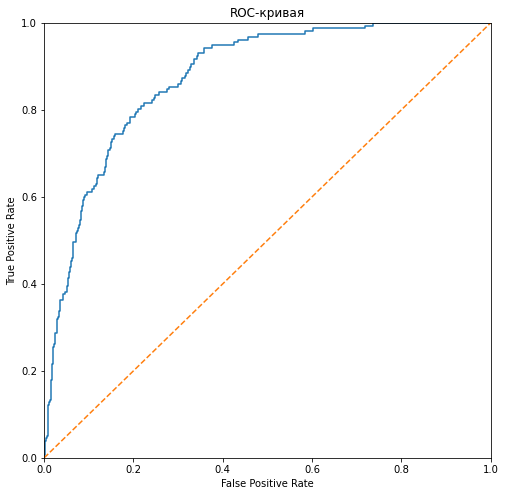

ROC-AUC: 0.8751252098404084


In [30]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [31]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [32]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8772527140928146,
 {'num_leaves': 100,
  'n_estimators': 700,
  'max_depth': 5,
  'learning_rate': 0.005,
  'boosting_type': 'goss'})

In [33]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [34]:
models_results['model'].append(grid_lgbm.best_estimator_)
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['description'].append('LGBM_all_features_without_pipline')

In [35]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,avg_glucose_level,5460
1,bmi,5129
2,age,4154
3,ever_married,571
4,gender,523
5,residence_type,441
6,smoking_status,437
7,work_type,284
8,heart_disease,212
9,hypertension,156


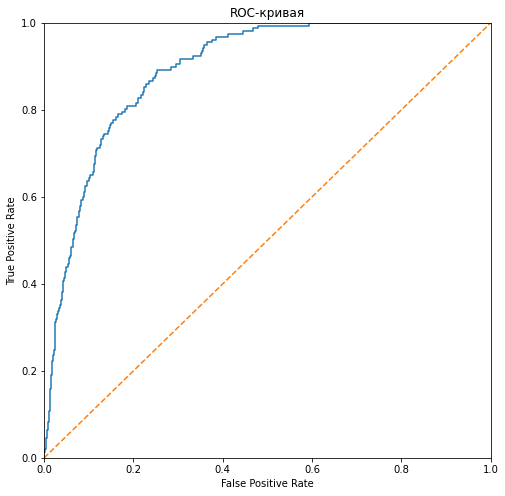

ROC-AUC: 0.8930755703232279


In [36]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Подбор моделей

# Модели с Pipline

In [37]:
train_df = make_features(train)
X_df = train_df.drop('stroke', axis=1)
y_df = train_df[['stroke']]
X_df_pl = pl.fit_transform(X_df)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11478, 10), (3826, 10), (11478, 1), (3826, 1))

# Catboost

In [38]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6888361	test: 0.6888997	test1: 0.6887444	best: 0.6887444 (0)	total: 12.5ms	remaining: 1.24s
99:	learn: 0.4787415	test: 0.4857176	test1: 0.4857987	best: 0.4857987 (99)	total: 292ms	remaining: 0us

bestTest = 0.4857986635
bestIteration = 99

0:	learn: 0.6895412	test: 0.6895983	test1: 0.6895468	best: 0.6895468 (0)	total: 17.4ms	remaining: 1.72s
99:	learn: 0.4843877	test: 0.4878457	test1: 0.4908907	best: 0.4908907 (99)	total: 307ms	remaining: 0us

bestTest = 0.4908906585
bestIteration = 99

0:	learn: 0.6891251	test: 0.6891145	test1: 0.6889540	best: 0.6889540 (0)	total: 4.01ms	remaining: 397ms
99:	learn: 0.4889581	test: 0.4895275	test1: 0.4909538	best: 0.4909538 (99)	total: 277ms	remaining: 0us

bestTest = 0.4909538031
bestIteration = 99

0:	learn: 0.6892090	test: 0.6893795	test1: 0.6894544	best: 0.6894544 (0)	total: 16.6ms	remaining: 1.65s
99:	learn: 0.4725205	test: 0.4832038	test1: 0.4838504	best: 0.4838504 (99)	total: 294ms	remaining: 0us

bestTest = 0.483850372
bestIteration

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001D431E5F940>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [39]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8811485798076875,
 {'learning_rate': 0.1, 'l2_leaf_reg': 2, 'iterations': 150, 'depth': 4})

In [40]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6525314	total: 2.66ms	remaining: 396ms
1:	learn: 0.6207279	total: 4.41ms	remaining: 326ms
2:	learn: 0.5962192	total: 5.97ms	remaining: 293ms
3:	learn: 0.5750958	total: 7.36ms	remaining: 269ms
4:	learn: 0.5574327	total: 8.81ms	remaining: 256ms
5:	learn: 0.5393462	total: 10.7ms	remaining: 258ms
6:	learn: 0.5242770	total: 12.3ms	remaining: 251ms
7:	learn: 0.5131832	total: 13.8ms	remaining: 245ms
8:	learn: 0.5021437	total: 15.2ms	remaining: 239ms
9:	learn: 0.4932156	total: 16.7ms	remaining: 234ms
10:	learn: 0.4846915	total: 18.2ms	remaining: 230ms
11:	learn: 0.4772436	total: 19.6ms	remaining: 225ms
12:	learn: 0.4715507	total: 21ms	remaining: 221ms
13:	learn: 0.4653517	total: 22.7ms	remaining: 220ms
14:	learn: 0.4606303	total: 24.2ms	remaining: 218ms
15:	learn: 0.4564038	total: 25.7ms	remaining: 215ms
16:	learn: 0.4531901	total: 27.2ms	remaining: 212ms
17:	learn: 0.4499298	total: 28.6ms	remaining: 210ms
18:	learn: 0.4463552	total: 30.1ms	remaining: 207ms
19:	learn: 0.4439563	tot

In [41]:
models_results['model'].append(grid_cbc.best_estimator_)
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['description'].append('Catboost_all_features_pipline')

In [42]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,53.875943
1,avg_glucose_level,16.724893
2,bmi,12.381485
3,smoking_status,4.679503
4,work_type,3.613745
5,ever_married,2.833643
6,gender,2.403084
7,residence_type,1.471274
8,hypertension,1.033754
9,heart_disease,0.982675


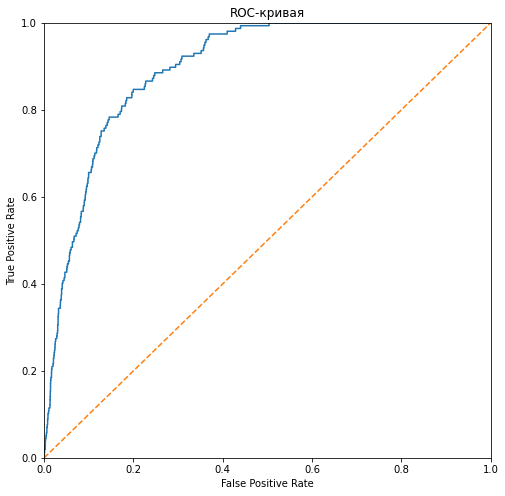

ROC-AUC: 0.8964217327826703


In [43]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [44]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [45]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8648042248056675,
 {'num_leaves': 119,
  'n_estimators': 700,
  'max_depth': 9,
  'learning_rate': 0.01,
  'boosting_type': 'gbdt'})

In [46]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [47]:
models_results['model'].append(grid_lgbm.best_estimator_)
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['description'].append('LGBM_all_features_pipline')

In [48]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,bmi,27918
1,avg_glucose_level,22867
2,age,16263
3,smoking_status,3528
4,gender,2691
5,residence_type,2028
6,work_type,1794
7,ever_married,1678
8,hypertension,626
9,heart_disease,471


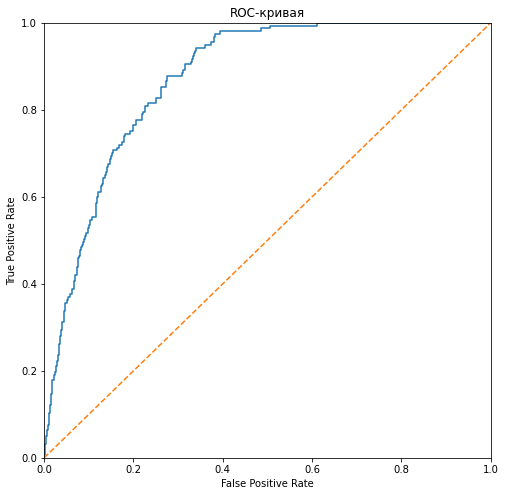

ROC-AUC: 0.8724500158845065


In [49]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Модели c Pipline и с Upsample

In [50]:
X_df_pl = pl.fit_transform(X_df)
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=.25, random_state=state)
upsample_make(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11478, 10), (3826, 10), (11478, 1), (3826, 1))

# Catboost

In [51]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 500)
cbc = CatBoostClassifier(random_state=state
#                          , cat_features=cat_features
                         , auto_class_weights='Balanced')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='roc_auc', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.6888361	test: 0.6888997	test1: 0.6887444	best: 0.6887444 (0)	total: 17.1ms	remaining: 840ms
49:	learn: 0.5503632	test: 0.5542633	test1: 0.5540773	best: 0.5540773 (49)	total: 149ms	remaining: 0us

bestTest = 0.5540772585
bestIteration = 49

0:	learn: 0.6895412	test: 0.6895983	test1: 0.6895468	best: 0.6895468 (0)	total: 3.37ms	remaining: 165ms
49:	learn: 0.5540396	test: 0.5561507	test1: 0.5571778	best: 0.5571778 (49)	total: 141ms	remaining: 0us

bestTest = 0.5571778266
bestIteration = 49

0:	learn: 0.6891251	test: 0.6891145	test1: 0.6889540	best: 0.6889540 (0)	total: 12.2ms	remaining: 598ms
49:	learn: 0.5572209	test: 0.5574115	test1: 0.5576108	best: 0.5576108 (49)	total: 144ms	remaining: 0us

bestTest = 0.557610784
bestIteration = 49

0:	learn: 0.6892090	test: 0.6893795	test1: 0.6894544	best: 0.6894544 (0)	total: 3.43ms	remaining: 168ms
49:	learn: 0.5465492	test: 0.5525204	test1: 0.5530796	best: 0.5530796 (49)	total: 136ms	remaining: 0us

bestTest = 0.5530795963
bestIteration

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001D4319438B0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [52]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8808414296668253,
 {'learning_rate': 0.1, 'l2_leaf_reg': 4, 'iterations': 100, 'depth': 4})

In [53]:
best_cbc.fit(X_train, y_train)
pred = best_cbc.predict(X_val)
pred_prob = best_cbc.predict_proba(X_val)[:,1]

0:	learn: 0.6526760	total: 1.67ms	remaining: 165ms
1:	learn: 0.6210126	total: 3.3ms	remaining: 162ms
2:	learn: 0.5966188	total: 4.83ms	remaining: 156ms
3:	learn: 0.5756536	total: 6.3ms	remaining: 151ms
4:	learn: 0.5580440	total: 7.88ms	remaining: 150ms
5:	learn: 0.5400133	total: 9.39ms	remaining: 147ms
6:	learn: 0.5249845	total: 10.8ms	remaining: 144ms
7:	learn: 0.5138708	total: 12.3ms	remaining: 142ms
8:	learn: 0.5028323	total: 14.1ms	remaining: 142ms
9:	learn: 0.4938961	total: 15.5ms	remaining: 140ms
10:	learn: 0.4853987	total: 17ms	remaining: 137ms
11:	learn: 0.4779949	total: 18.5ms	remaining: 135ms
12:	learn: 0.4723040	total: 20.1ms	remaining: 134ms
13:	learn: 0.4661330	total: 21.6ms	remaining: 133ms
14:	learn: 0.4614233	total: 23.2ms	remaining: 131ms
15:	learn: 0.4571736	total: 24.6ms	remaining: 129ms
16:	learn: 0.4539501	total: 26.1ms	remaining: 128ms
17:	learn: 0.4506955	total: 27.6ms	remaining: 126ms
18:	learn: 0.4471501	total: 29.2ms	remaining: 125ms
19:	learn: 0.4447472	total

In [54]:
models_results['model'].append(grid_cbc.best_estimator_)
models_results['best_score'].append(grid_cbc.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['description'].append('Catboost_all_feat_pipline_upsample')

In [55]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,64.934264
1,avg_glucose_level,11.472095
2,bmi,7.529730
3,smoking_status,4.662377
4,work_type,3.450308
5,ever_married,2.678059
6,gender,2.454576
7,hypertension,1.115235
8,heart_disease,1.043715
9,residence_type,0.659642


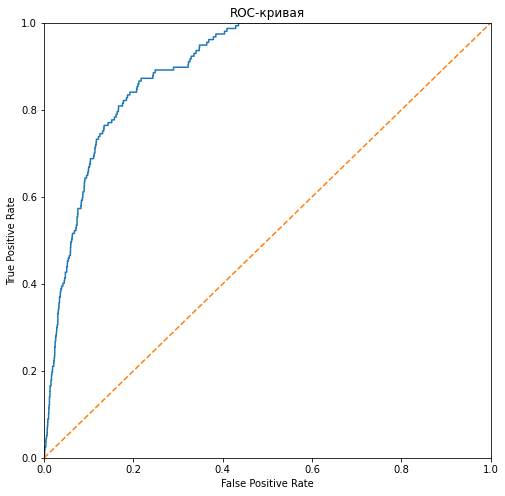

ROC-AUC: 0.898747988396498


In [56]:
predict = best_cbc.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# LGBM

In [57]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 1000)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='roc_auc', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10012023, test_size=0.25,
       train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=10012023),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='roc_auc')

In [58]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8814804590973082,
 {'num_leaves': 96,
  'n_estimators': 780,
  'max_depth': 2,
  'learning_rate': 0.01,
  'boosting_type': 'goss'})

In [59]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
pred_prob = best_lgbm.predict_proba(X_val)[:,1]

In [60]:
models_results['model'].append(grid_lgbm.best_estimator_)
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['rocauc'].append(roc_auc_score(y_val, pred_prob))
models_results['precision'].append(precision_score(pred, y_val))
models_results['recall'].append(recall_score(pred, y_val))
models_results['description'].append('LGBM__all_feat_pipline_upsample')

In [61]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,age,903
1,avg_glucose_level,562
2,bmi,457
3,work_type,114
4,smoking_status,93
5,heart_disease,46
6,ever_married,39
7,gender,30
8,hypertension,28
9,residence_type,16


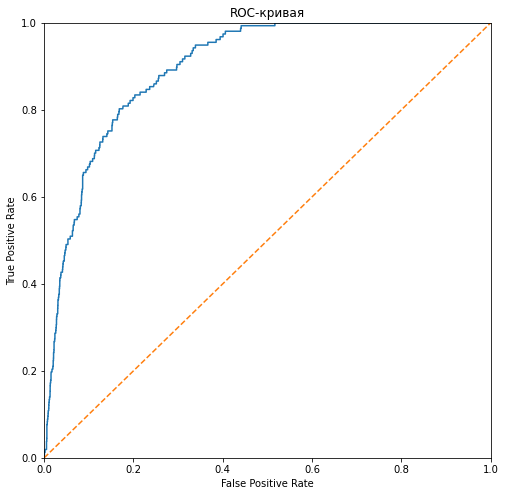

ROC-AUC: 0.8973678591330705


In [62]:
predict = best_lgbm.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, predict)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("ROC-AUC:", roc_auc_score(y_val, predict))

# Тестирование

In [68]:
pd.DataFrame(data=models_results).sort_values(by='rocauc', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')

,model,best_score,rocauc,precision,recall,description
4,,0.880841,0.898748,0.872611,0.144211,Catboost_all_feat_pipline_upsample
5,"LGBMClassifier(boosting_type='goss', class_weight='balanced', learning_rate=0.01, max_depth=2, n_estimators=780, num_leaves=96, random_state=10012023)",0.881480,0.897368,0.847134,0.133938,LGBM__all_feat_pipline_upsample
2,,0.881149,0.896422,0.840764,0.153488,Catboost_all_features_pipline
1,"LGBMClassifier(boosting_type='goss', class_weight='balanced', learning_rate=0.005, max_depth=5, n_estimators=700, num_leaves=100, random_state=10012023)",0.877253,0.893076,0.808917,0.149061,LGBM_all_features_without_pipline
0,,0.879207,0.875125,0.745223,0.165488,Catboost_all_features_without_pipline
3,"LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=9, n_estimators=700, num_leaves=119, random_state=10012023)",0.864804,0.872450,0.547771,0.184946,LGBM_all_features_pipline


In [69]:
X_all, y_all = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])

In [70]:
# обучим модель на всех данных
best_cbc.fit(X_all, y_all)
X_test_pl = pl.fit_transform(test)
# сделаем предсказания на тестовых данных
predicted = best_cbc.predict_proba(X_test_pl)[:, 1] 

0:	learn: 0.6524471	total: 1.67ms	remaining: 165ms
1:	learn: 0.6193800	total: 3.35ms	remaining: 164ms
2:	learn: 0.5948262	total: 4.86ms	remaining: 157ms
3:	learn: 0.5705554	total: 6.39ms	remaining: 153ms
4:	learn: 0.5523932	total: 8.02ms	remaining: 152ms
5:	learn: 0.5339340	total: 9.58ms	remaining: 150ms
6:	learn: 0.5187410	total: 11.3ms	remaining: 150ms
7:	learn: 0.5061866	total: 13.1ms	remaining: 150ms
8:	learn: 0.4954429	total: 14.8ms	remaining: 149ms
9:	learn: 0.4866422	total: 16.8ms	remaining: 151ms
10:	learn: 0.4788795	total: 18.5ms	remaining: 150ms
11:	learn: 0.4715804	total: 20.1ms	remaining: 147ms
12:	learn: 0.4650994	total: 21.7ms	remaining: 145ms
13:	learn: 0.4591173	total: 23.2ms	remaining: 142ms
14:	learn: 0.4536355	total: 24.6ms	remaining: 140ms
15:	learn: 0.4496535	total: 26.1ms	remaining: 137ms
16:	learn: 0.4460397	total: 27.8ms	remaining: 136ms
17:	learn: 0.4421444	total: 29.4ms	remaining: 134ms
18:	learn: 0.4383421	total: 30.9ms	remaining: 132ms
19:	learn: 0.4361478	t

In [71]:
# запишем предсказания
submission['stroke'] = predicted
submission.to_csv('submission.csv', index = False)

In [72]:
pd.read_csv('submission.csv').head()

,id,stroke
0,15304,0.391206
1,15305,0.846997
2,15306,0.013511
3,15307,0.697155
4,15308,0.093088


In [73]:
pd.read_csv('submission.csv').shape

(10204, 2)